# **Influence de l'Energy Star Score**

<a name="Imports"></a>
## **Import des jeux de données**:

In [8]:
from ast import literal_eval 

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)

import statistics
import re
use_colab=True
if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
datasNR = pd.read_csv('/content/drive/MyDrive/datasNR.csv',sep='\t')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Le score ENERGY STAR donne un aperçu de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Ce score est comparé aux autres bâtiments dans le monde.

Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment. 50 est le score médian.

On va regarder son influence sur les performances des modèles et sur nos prédictions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


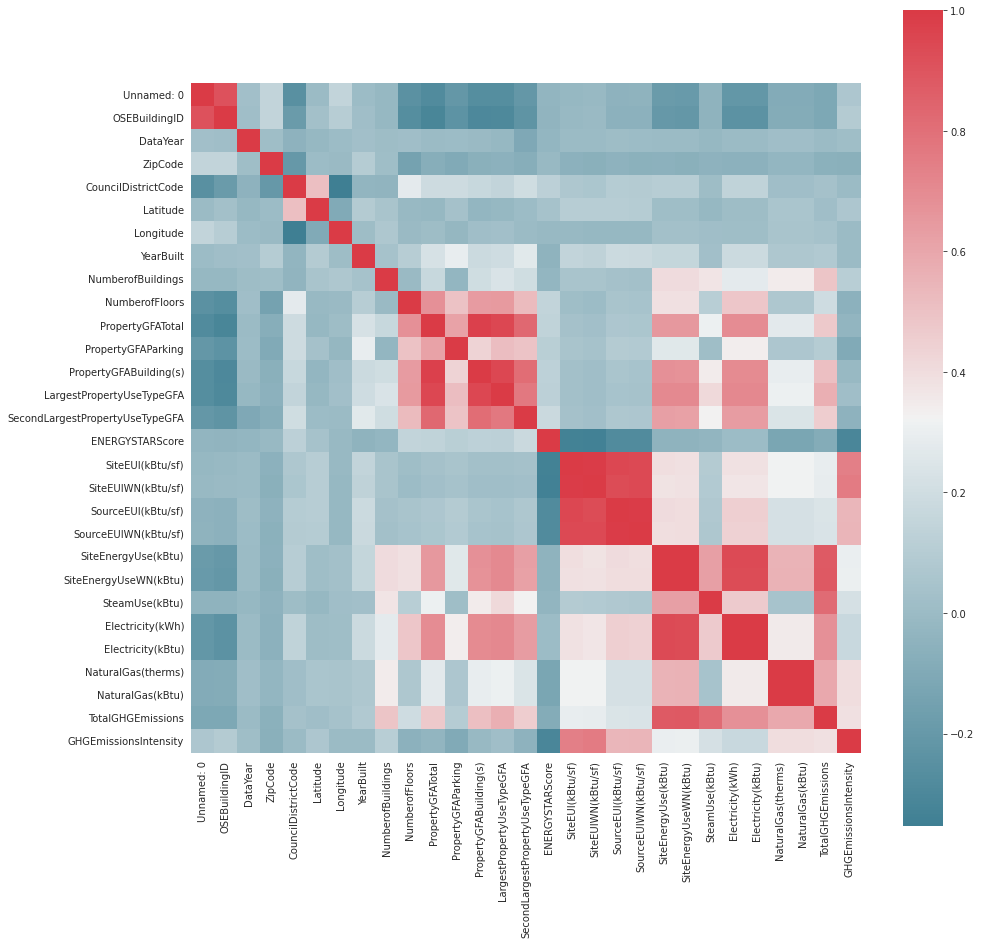

In [9]:
datasNR.corr(method = "pearson")
corr = datasNR.corr(method = "pearson")

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [10]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print('Le top 20 des corrélations entre variables est: \n{}'.format(get_top_abs_correlations(datasNR.select_dtypes(include=float), n=20)))

Le top 20 des corrélations entre variables est: 
NaturalGas(therms)         NaturalGas(kBtu)                   1.000000
Electricity(kWh)           Electricity(kBtu)                  1.000000
SiteEnergyUse(kBtu)        SiteEnergyUseWN(kBtu)              0.995751
SourceEUI(kBtu/sf)         SourceEUIWN(kBtu/sf)               0.994481
SiteEUI(kBtu/sf)           SiteEUIWN(kBtu/sf)                 0.993605
                           SourceEUI(kBtu/sf)                 0.949273
                           SourceEUIWN(kBtu/sf)               0.945944
SiteEUIWN(kBtu/sf)         SourceEUIWN(kBtu/sf)               0.944560
SiteEnergyUse(kBtu)        Electricity(kWh)                   0.938973
                           Electricity(kBtu)                  0.938973
SiteEUIWN(kBtu/sf)         SourceEUI(kBtu/sf)                 0.936482
SiteEnergyUseWN(kBtu)      Electricity(kBtu)                  0.933514
                           Electricity(kWh)                   0.933514
                           T

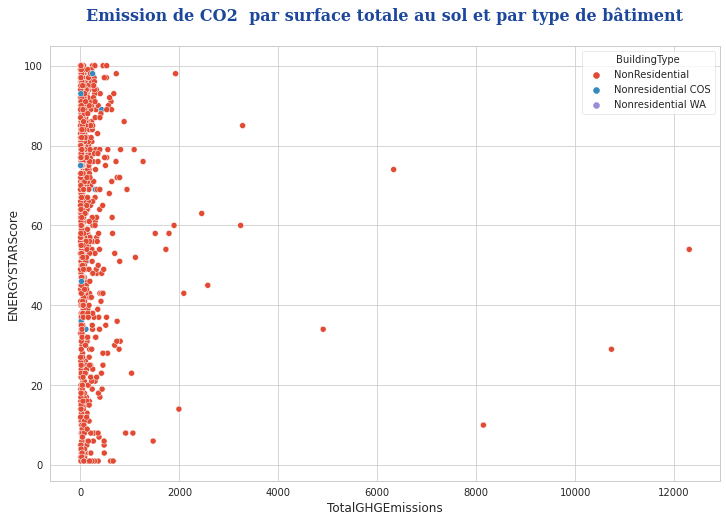

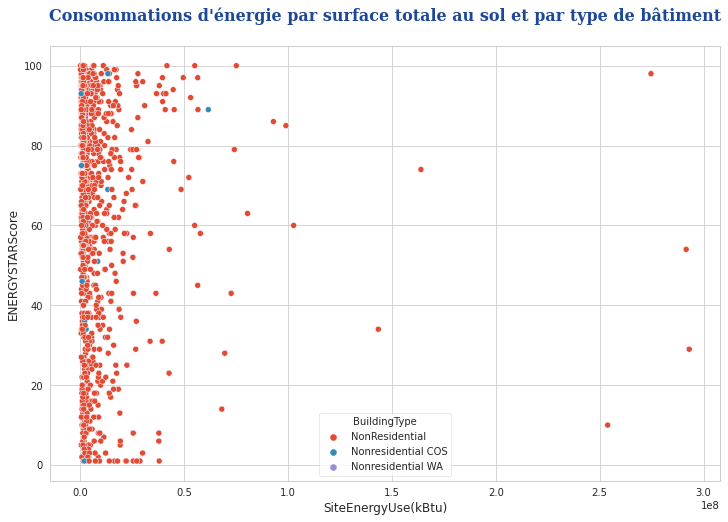

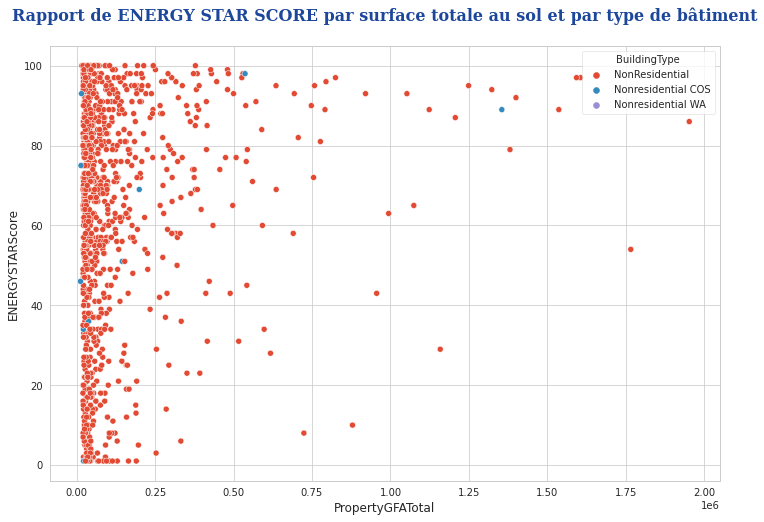

In [11]:
data=datasNR

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='TotalGHGEmissions', y='ENERGYSTARScore', hue='BuildingType')
plt.title(f"Emission de CO2  par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='SiteEnergyUse(kBtu)', y='ENERGYSTARScore', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='ENERGYSTARScore', hue='BuildingType')
plt.title(f"Rapport de ENERGY STAR SCORE par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)
plt.show()


En observant nos graphiques ci-dessus, on observe pas de vraies relations entre l'EnergyStarScore et l'émission de CO2 ainsi que la consommation d'énergie.

On observe ci-dessous la distribution de l'EnergyStarScore et on observe que la majorité des batiments ont un score supérieur à 50. On a pas de distribution normale.

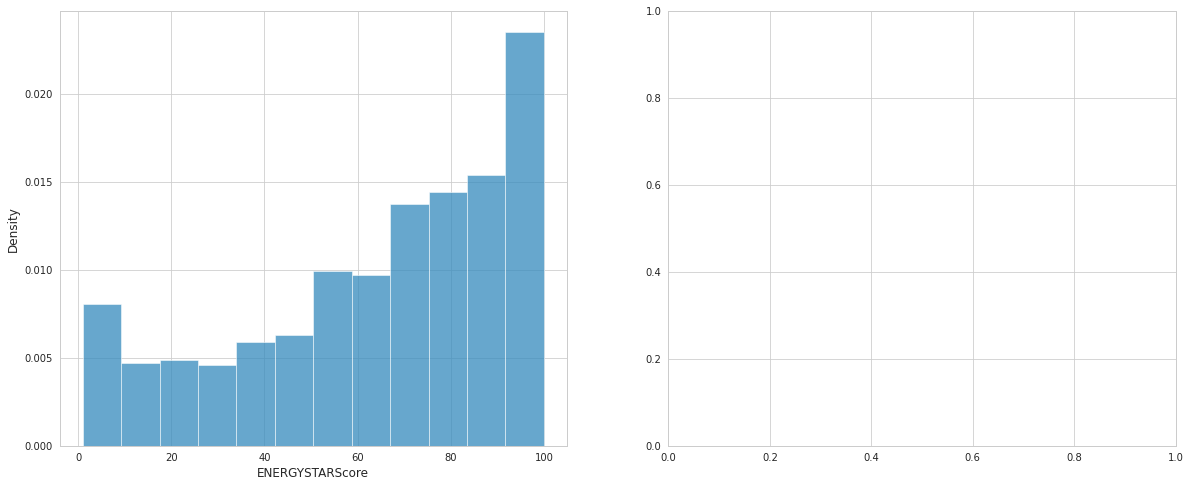

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=datasNR, x='ENERGYSTARScore', stat="density", ax=axes[0])


In [13]:
data_filter = data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

numerical_features = data_filter.select_dtypes(include=['int64','float64'])
categorical_features = data_filter.select_dtypes(exclude=['int64','float64']) 
categorical_features = categorical_features.drop(['State'], axis=1)

numerical_features = numerical_features.drop(['DataYear'], axis=1)
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

In [14]:
from sklearn.model_selection import train_test_split

X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = data_filter[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))
target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']

Entrainement: 1258 lignes,
Test: 315 lignes.



In [15]:
pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.5 MB/s 


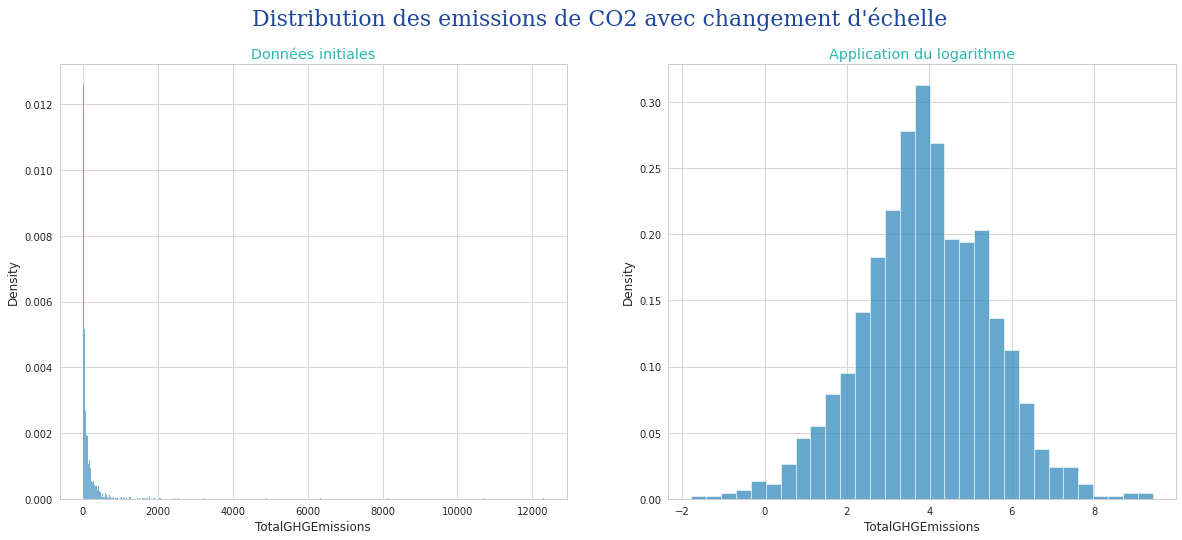

In [16]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_trainlog = logtransformer.transform(Y_train)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y_train, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_trainlog, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

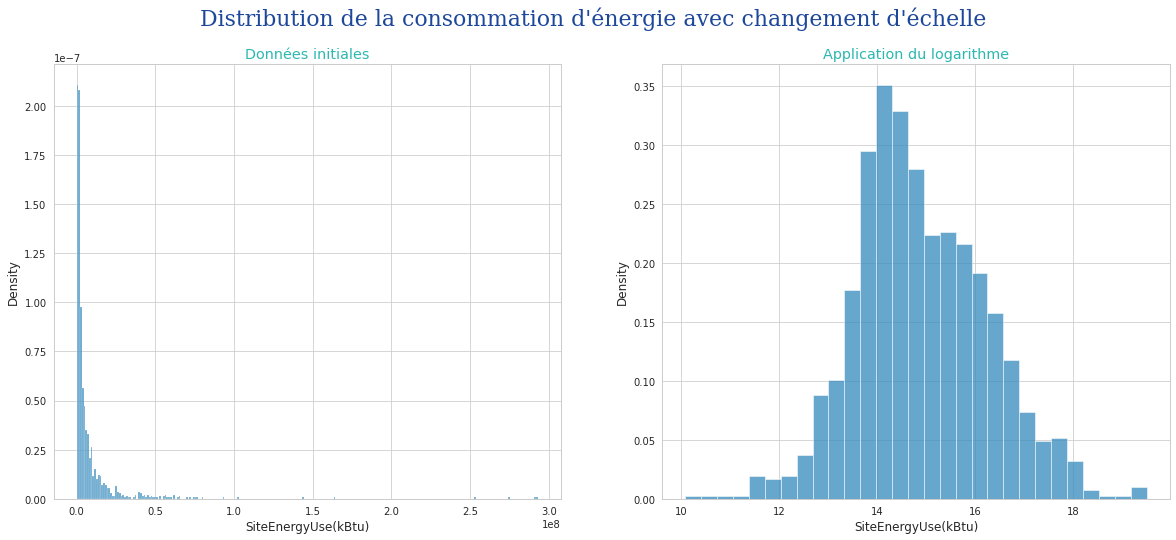

In [17]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_trainlog = logtransformer.transform(Y_train)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y_train, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_trainlog, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution de la consommation d'énergie avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

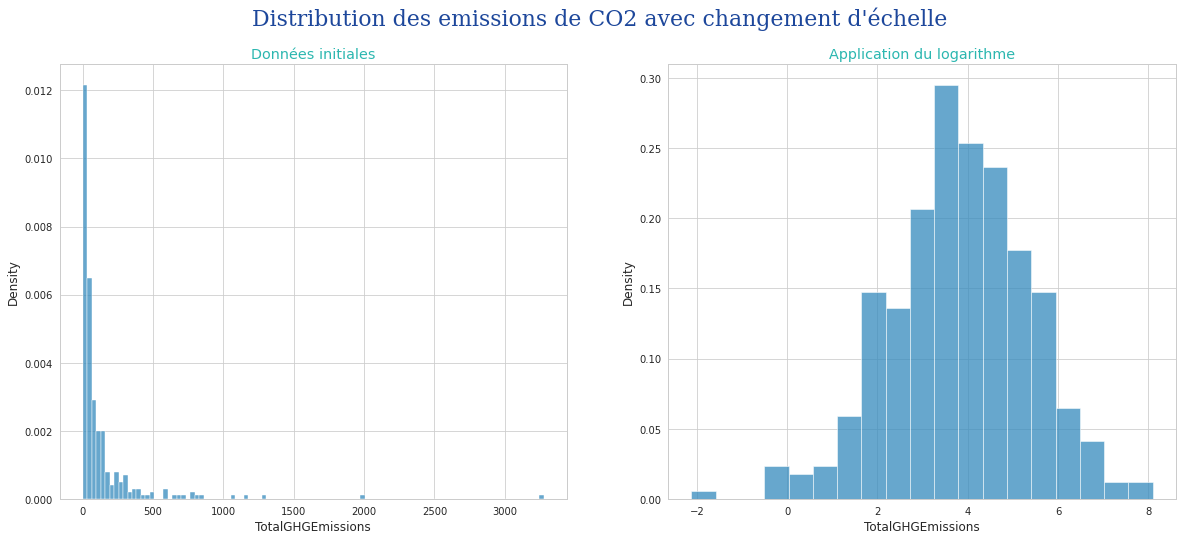

In [18]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_testlog = logtransformer.transform(Y_test)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y_test, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_testlog, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

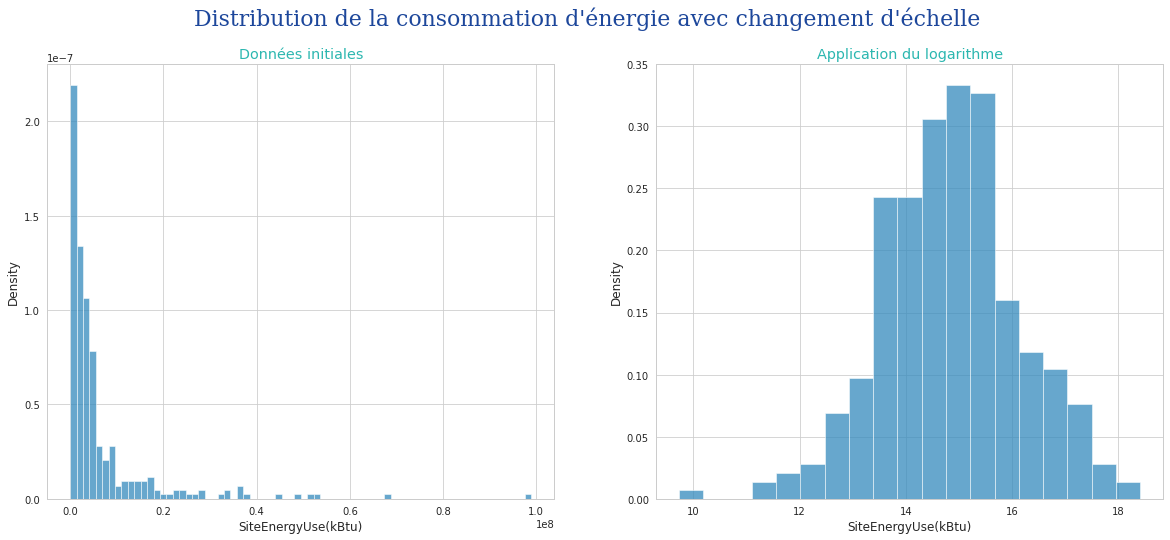

In [19]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_testlog = logtransformer.transform(Y_test)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y_test, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_testlog, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution de la consommation d'énergie avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

In [20]:
Y_train

,TotalGHGEmissions,SiteEnergyUse(kBtu)
1041,13.91,1.994968e+06
277,249.09,1.929523e+07
1223,42.24,6.058494e+06
925,15.11,8.735773e+05
1161,41.77,2.186148e+06
...,...,...
1130,30.99,1.195165e+06
1294,183.79,7.202142e+06
860,44.33,1.832809e+06
1459,3.39,4.859710e+05


In [21]:
import category_encoders as ce

from category_encoders import TargetEncoder

encoder = TargetEncoder()

for col in categorical_features:
   X_train[col] = encoder.fit_transform(X_train[col], Y_trainlog['TotalGHGEmissions'])
   X_test[col] = encoder.fit_transform(X_test[col], Y_testlog['TotalGHGEmissions'])
   


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [22]:
for col in X_train:
  
  X_train[col].fillna(value=X_train[col].mean() , inplace=True) 


for col in X_test:
  
  X_test[col].fillna(value=X_test[col].mean() , inplace=True) 


for col in Y_train:
  
  Y_train[col].fillna(value=Y_train[col].mean() , inplace=True) 


for col in Y_test:
  
  Y_test[col].fillna(value=Y_test[col].mean() , inplace=True) 

In [23]:
Y_train['SiteEnergyUse(kBtu)']=logtransformer.transform(Y_train['SiteEnergyUse(kBtu)'])
Y_test['SiteEnergyUse(kBtu)']=logtransformer.transform(Y_test['SiteEnergyUse(kBtu)'])


In [24]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [25]:
X_train.dtypes

BuildingType                       float64
PrimaryPropertyType                float64
PropertyName                       float64
Address                            float64
City                               float64
TaxParcelIdentificationNumber      float64
Neighborhood                       float64
ListOfAllPropertyUseTypes          float64
LargestPropertyUseType             float64
SecondLargestPropertyUseType       float64
DefaultData                        float64
ComplianceStatus                   float64
Unnamed: 0                           int64
OSEBuildingID                        int64
ZipCode                            float64
CouncilDistrictCode                  int64
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                    int64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFA

In [26]:
Y_train.isnull().any()

TotalGHGEmissions      False
SiteEnergyUse(kBtu)    False
dtype: bool

In [27]:
Y_test

,TotalGHGEmissions,SiteEnergyUse(kBtu)
1120,2.82,12.911767
810,45.33,13.954525
1339,48.13,15.227424
534,119.03,16.653076
514,68.06,15.973718
...,...,...
1263,66.32,16.068152
1281,63.81,14.553964
1209,22.62,14.992660
1007,19.12,14.499171


In [28]:
## Importing Random Forest Classifier from the sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)




rf_random.fit(X_train, Y_train['TotalGHGEmissions'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [29]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')
#todo : justifier temps de calcul et expliquer, voir si on peut passer les best parameters en entrée pour éviter les copier coller

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}  



In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import timeit 
start_time=timeit.default_timer()
from sklearn.metrics import r2_score


In [31]:
randmf = RandomForestRegressor(n_estimators = 20, min_samples_split = 6, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 10, bootstrap=True) 
randmf.fit( X_train, Y_train['TotalGHGEmissions']) 
rm=randmf

In [32]:
Y_pred = rm.predict(X_test)
MSE_rm=mean_squared_error(Y_test['TotalGHGEmissions'],Y_pred)
print('NotY_pred = rm.predict(X_test)re MSE est égal à %0.2f' %MSE_rm)
#mae = mean_absolute_error(y_test, y_predi)
#print('MAE: %.3f' % mae)
MAPE= mean_absolute_percentage_error(Y_test['TotalGHGEmissions'], Y_pred) * 100

print('MAPE :' ,round(MAPE,2), '%')
# Evaluation du training set

rmtime= timeit.default_timer()-start_time
print('Voici le temps de calcul en ms',round(rmtime,2))   
rmse_rm = (np.sqrt(mean_squared_error(Y_test['TotalGHGEmissions'], Y_pred)))
r2_rm= r2_score(Y_test['TotalGHGEmissions'], Y_pred)
#print('La performance du modèle sur la base dapprentissage')
#print('--------------------------------------')
print('RMSE est {}'.format(rmse_rm))
print('le score R2 coeff de determination est de %0.2f' %(r2_rm))
#print('\n')
print('MSE Train Score :', round(rm.score(X_train,Y_train['TotalGHGEmissions'])),2)
print('MSE Test Score :',round(rm.score(X_test,Y_test['TotalGHGEmissions'])),2)

NotY_pred = rm.predict(X_test)re MSE est égal à 7251.20
MAPE : 114.65 %
Voici le temps de calcul en ms 0.12
RMSE est 85.15397175160587
le score R2 coeff de determination est de 0.90
MSE Train Score : 1 2
MSE Test Score : 1 2


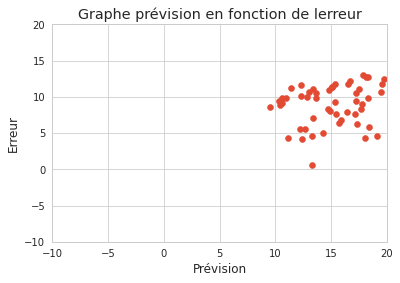

In [33]:
erreur=Y_pred-Y_test['TotalGHGEmissions'] #erreur de prédiction 
plt.figure()
plt.scatter(Y_pred,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.xlim(-10,20)
plt.ylim(-10,20)
plt.title('Graphe prévision en fonction de lerreur')
plt.show()

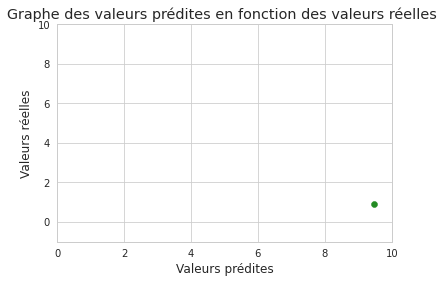

In [34]:
plt.figure()
plt.scatter(Y_pred,Y_test['TotalGHGEmissions'],c='forestgreen')

plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles ')
plt.xlim(0,10)
plt.ylim(-1,10)
plt.show()

In [35]:
randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf= 1, max_features = 'sqrt', max_depth= 90, bootstrap=True) 
randmf.fit( X_train, Y_train['SiteEnergyUse(kBtu)']) 
rm=randmf

In [36]:
Y_train['SiteEnergyUse(kBtu)']

1041    14.506138
277     16.775368
1223    15.616972
925     13.680352
1161    14.597652
          ...    
1130    13.993795
1294    15.789889
860     14.421360
1459    13.093904
1126    13.620270
Name: SiteEnergyUse(kBtu), Length: 1258, dtype: float64

In [37]:

Y_test['SiteEnergyUse(kBtu)'].fillna(value=Y_test['SiteEnergyUse(kBtu)'].mean() , inplace=True) 

In [38]:
SEU_pred = rm.predict(X_test)
MSE_rm_bis=mean_squared_error(Y_test['SiteEnergyUse(kBtu)'],SEU_pred)
print('NotY_pred = rm.predict(X_test)re MSE est égal à %0.2f' %MSE_rm_bis)
#mae = mean_absolute_error(y_test, y_predi)
#print('MAE: %.3f' % mae)
MAPE= mean_absolute_percentage_error(Y_test['SiteEnergyUse(kBtu)'], SEU_pred) * 100

print('MAPE :' ,round(MAPE,2), '%')
# Evaluation du training set

rmtime_bis= timeit.default_timer()-start_time
print('Voici le temps de calcul en ms',round(rmtime_bis,2))   
rmse_rm = (np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], SEU_pred)))
r2_rm_bis= r2_score(Y_test['SiteEnergyUse(kBtu)'], SEU_pred)
#print('La performance du modèle sur la base dapprentissage')
#print('--------------------------------------')
print('RMSE est {}'.format(rmse_rm))
print('le score R2 coeff de determination est de %0.2f' %(r2_rm_bis))
#print('\n')
print('MSE Train Score :', round(rm.score(X_train,Y_train['SiteEnergyUse(kBtu)']),2))
print('MSE Test Score :', round(rm.score(X_test,Y_test['SiteEnergyUse(kBtu)']),2))

NotY_pred = rm.predict(X_test)re MSE est égal à 0.02
MAPE : 0.56 %
Voici le temps de calcul en ms 1.17
RMSE est 0.1469552944273524
le score R2 coeff de determination est de 0.99
MSE Train Score : 1.0
MSE Test Score : 0.99


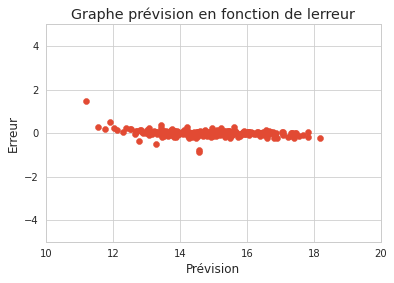

In [39]:
erreur=SEU_pred-Y_test['SiteEnergyUse(kBtu)'] #erreur de prédiction 
plt.figure()
plt.scatter(SEU_pred,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.xlim(10,20)
plt.ylim(-5,5)
plt.title('Graphe prévision en fonction de lerreur')
plt.show()

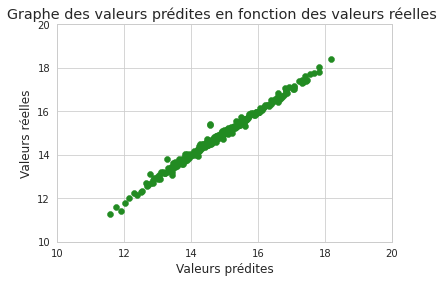

In [40]:
plt.figure()
plt.scatter(SEU_pred,Y_test['SiteEnergyUse(kBtu)'],c='forestgreen')

plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles ')
plt.xlim(10,20)
plt.ylim(10,20)
plt.show()